## Implementación de un clasificador de estilo de ajedrez usando redes neuronales

# Instalación de dependencias

In [ ]:
!pip install tensorflow imbalanced-learn joblib python-chess chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 49.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:

# Importación de librerías

In [ ]:
import chess
import chess.pgn
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load
import io
import chardet
import random
from google.colab import files

# Clase principal del analizador

In [ ]:
class ChessStyleAnalyzer:
    def __init__(self):

        # Mapeos de estilos
        self.style_mapping = {
            'Steinitz, Wilhelm': 'positional_classic',
            'Capablanca, José': 'positional_classic',
            'Karpov, Anatoly': 'positional_classic',
            'Kramnik, Vladimir': 'positional_classic',
            'Alekhine, Alexander': 'aggressive_dynamical',
            'Fischer, Robert James': 'aggressive_dynamical',
            'Kasparov, Garry': 'aggressive_dynamical',
            'Tal, Mikhail': 'aggressive_dynamical',
            'Petrosian, Tigran': 'defensive_prophylactic',
            'Lasker, Emanuel': 'defensive_prophylactic',
            'Spassky, Boris': 'universal_practical',
            'Anand, Viswanathan': 'universal_practical',
            'Carlsen, Magnus': 'universal_practical',
            'Botvinnik, Mikhail': 'scientific_technical',
            'Euwe, Max': 'scientific_technical'
        }

        # Calcular número de clases únicas
        self.unique_styles = list(set(self.style_mapping.values()))  # Obtener estilos únicos
        self.num_classes = len(self.unique_styles)  # Debería ser 5

        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.unique_styles)
        self.model = self._build_neural_network()

        self.champion_mapping = {
            'positional_classic': [
                ('Karpov, Anatoly', 'Maestro del juego posicional'),
                ('Capablanca, José', 'Genio del juego simple y claro'),
                ('Kramnik, Vladimir', 'Especialista en transposiciones')
            ],
            'aggressive_dynamical': [
                ('Kasparov, Garry', 'Ataques dinámicos y preparación de aperturas'),
                ('Fischer, Robert James', 'Juego agudo y preciso'),
                ('Alekhine, Alexander', 'Ataques imaginativos'),
                ('Tal, Mikhail', 'Maestro de los sacrificios')
            ],
            'universal_practical': [
                ('Carlsen, Magnus', 'Adaptabilidad moderna'),
                ('Spassky, Boris', 'Estilo completo y versátil'),
                ('Anand, Viswanathan', 'Universalidad práctica')
            ],
            'scientific_technical': [
                ('Botvinnik, Mikhail', 'Padre del ajedrez científico'),
                ('Euwe, Max', 'Precisión técnica'),
                ('Petrosian, Tigran', 'Estrategia profiláctica')
            ],
            'defensive_prophylactic': [
                ('Petrosian, Tigran', 'Maestro de la defensa'),
                ('Lasker, Emanuel', 'Defensa práctica y psicológica')
            ]
        }

        self.opening_mapping = {
            'positional_classic': [
                ('E00', 'Apertura Catalana'),
                ('D37', 'Gambito de Dama Declinado'),
                ('A04', 'Apertura Reti'),
                ('D05', 'Sistema Colle')
            ],
            'aggressive_dynamical': [
                ('C30', 'Gambito de Rey'),
                ('A45', 'Apertura Trompowsky'),
                ('E60', 'India de Rey')
            ],
            'universal_practical': [
                ('A00', 'Apertura Inglesa'),
                ('D02', 'Sistema Londres'),
            ],
            'scientific_technical': [
                ('E12', 'India de Rey'),
                ('C65', 'Apertura Española'),
                ('D10', 'Gambito de Dama Aceptado')
            ],
            'defensive_prophylactic': [
                ('A46', 'Apertura de Torre'),
                ('D02', 'Sistema Londres')
            ]
        }

    def _build_neural_network(self):
        model = Sequential([
            Dense(256, activation='relu', input_shape=(420,)),
            # No usar ambos regularizadores al mismo tiempo
            # Probar primero una red neuronal sin regularizadores con 10 o 15 epocas
            # Probablemente mejor BatchNormalization
            BatchNormalization(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dense(64, activation='relu'), # Capaz considerar Dropout(0.2)
            #Dropout(0.2),
            Dense(self.num_classes, activation='softmax')  # Usar self.num_classes
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def process_pgns(self):
        """Procesa archivos PGN subidos y extrae características"""
        uploaded = files.upload()
        features = []
        labels = []

        for filename, content in uploaded.items():
            try:
                # Detección de codificación
                enc = chardet.detect(content)['encoding'] or 'latin-1'
                pgn_text = content.decode(enc, errors='replace')
                pgn = io.StringIO(pgn_text)

                while True:
                    game = chess.pgn.read_game(pgn)
                    if not game:
                        break

                    # Obtener estilo del jugador
                    white = game.headers.get('White', '').strip()
                    black = game.headers.get('Black', '').strip()
                    style = self.style_mapping.get(white) or self.style_mapping.get(black)

                    if style:
                        game_features = self._extract_game_features(game)
                        if game_features:
                            features.append(game_features)
                            labels.append(style)

            except Exception as e:
                print(f"Error procesando {filename}: {str(e)}")
                continue

        if not features:
            print("No hay datos válidos para entrenar")
            return False

        # Asegurar que el LabelEncoder se ajuste correctamente
        self.label_encoder.fit(list(set(self.style_mapping.values())))  # Forzar todas las clases

        # Preprocesamiento
        self.y = self.label_encoder.fit_transform(labels)
        self.X = self.scaler.fit_transform(features)

        # Podria aplicarse submuestreo y ya no seria necesario aplicar SMOTE

        # Balancear datos
        smote = SMOTE(k_neighbors=3)
        self.X, self.y = smote.fit_resample(self.X, self.y)

        print(f"\nDatos procesados: {len(self.X)} partidas")
        print("Distribución de estilos:", dict(zip(
            self.label_encoder.inverse_transform(np.unique(self.y)),
            np.bincount(self.y)
        )))
        return True

    def _extract_game_features(self, game):
      """Extrae características avanzadas de una partida de ajedrez"""
      MOVES_TO_ANALYZE = 30
      FEATURES_PER_MOVE = 14
      TOTAL_FEATURES = MOVES_TO_ANALYZE * FEATURES_PER_MOVE

      board = game.board()
      features = []
      previous_material = 0

      try:
          for move in list(game.mainline_moves())[:MOVES_TO_ANALYZE]:
              board.push(move)
              move_features = [
                  # Características estratégicas
                  self._calculate_material_balance(board),
                  self._king_safety_score(board),
                  self._pawn_structure_analysis(board),
                  self._piece_activity_score(board),
                  self._control_of_key_squares(board),
                  self._openness_position(board),
                  self._development_score(board),
                  self._sacrifice_detection(board, move, previous_material),
                  self._tactical_opportunities(board),
                  self._space_advantage(board),
                  self._piece_mobility(board),
                  self._attack_defense_ratio(board),
                  self._passed_pawns_count(board),
                  self._endgame_indicator(board)
              ]
              features.extend(move_features)
              previous_material = self._calculate_total_material(board)

          # Rellenar con ceros si la partida es más corta
          features += [0] * (TOTAL_FEATURES - len(features))
          return features[:TOTAL_FEATURES]

      except Exception as e:
          print(f"Error en extracción: {str(e)}")
          return None

    def _calculate_material_balance(self, board):
        """Balance material con valores de pieza ajustados"""
        piece_values = {
            chess.PAWN: 1.5,    # Valor ligeramente mayor por estructura
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,  # Par de alfiles bonus se maneja aparte
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        white = sum(len(board.pieces(pt, chess.WHITE)) * val for pt, val in piece_values.items())
        black = sum(len(board.pieces(pt, chess.BLACK)) * val for pt, val in piece_values.items())
        return (white - black) / 10  # Normalizado

    def _king_safety_score(self, board):
        """Evaluación detallada de la seguridad del rey"""
        king_square = board.king(board.turn)
        if not king_square:
            return 0

        safety_score = 0
        # Escudo de peones
        pawn_shield = sum(1 for sq in board.attacks(king_square) if board.piece_type_at(sq) == chess.PAWN)

        # Ataques potenciales
        attackers = len(board.attackers(not board.turn, king_square))

        # Posición del rey (centro vs esquina)
        file = chess.square_file(king_square)
        rank = chess.square_rank(king_square)
        center_distance = abs(3.5 - file) + abs(3.5 - rank)

        return (pawn_shield * 0.5) - (attackers * 0.3) - (center_distance * 0.2)

    def _piece_mobility(self, board):
        """Movilidad de las piezas (número de movimientos legales disponibles)"""
        mobility = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                mobility += len(board.attacks(sq))
        return mobility / 50  # Normalizado según movilidad máxima típica

    def _attack_defense_ratio(self, board):
        """Relación entre ataques y defensas en el tablero"""
        attack_count = 0
        defense_count = 0
        for square in chess.SQUARES:
            if board.piece_at(square):
                attack_count += len(board.attackers(board.turn, square))
                defense_count += len(board.attackers(not board.turn, square))
        if defense_count == 0:
            return 1.0 if attack_count > 0 else 0.0
        return (attack_count - defense_count) / (attack_count + defense_count)

    def _is_passed_pawn(self, board, pawn_square):
        """Verifica si un peón es pasado"""
        color = board.color_at(pawn_square)
        if color is None:
            return False

        pawn_file = chess.square_file(pawn_square)
        pawn_rank = chess.square_rank(pawn_square)

        # Determinar dirección según color
        direction = 1 if color == chess.WHITE else -1
        start_rank = pawn_rank + direction

        # Verificar casillas hacia adelante en columnas adyacentes
        for rank in range(start_rank, 8) if color == chess.WHITE else range(start_rank, -1, -1):
            for file_offset in (-1, 0, 1):
                current_file = pawn_file + file_offset
                if 0 <= current_file <= 7:
                    square = chess.square(current_file, rank)
                    # Verificar peones enemigos
                    if board.piece_type_at(square) == chess.PAWN and board.color_at(square) != color:
                        return False
        return True

    def _passed_pawns_count(self, board):
        """Conteo de peones pasados"""
        passed = 0
        pawns = board.pieces(chess.PAWN, board.turn)
        enemy_pawns = board.pieces(chess.PAWN, not board.turn)
        for pawn in pawns:
            is_passed = True
            pawn_file = chess.square_file(pawn)
            pawn_rank = chess.square_rank(pawn)
            # Verificar columnas adyacentes y frente del peón
            for file in [pawn_file-1, pawn_file, pawn_file+1]:
                if 0 <= file <= 7:
                    for rank in range(pawn_rank+1, 8):
                        if chess.square(file, rank) in enemy_pawns:
                            is_passed = False
                            break
                    if not is_passed:
                        break
            if is_passed:
                passed += 1
        return passed / 8  # Normalizado

    def _development_score(self, board):
        """Puntaje de desarrollo de piezas menores"""
        developed = 0
        # Para blancas: piezas en filas 0-1 son no desarrolladas
        # Para negras: piezas en filas 6-7 son no desarrolladas
        back_rank = 0 if board.turn == chess.WHITE else 7
        second_rank = 1 if board.turn == chess.WHITE else 6

        for piece_type in [chess.KNIGHT, chess.BISHOP]:
            for sq in board.pieces(piece_type, board.turn):
                if chess.square_rank(sq) not in [back_rank, second_rank]:
                    developed += 1
        # Máximo 4 piezas (2 caballos y 2 alfiles)
        return developed / 4

    def _pawn_structure_analysis(self, board):
        """Análisis completo de estructura de peones"""
        pawns = board.pieces(chess.PAWN, board.turn)
        score = 0

        # Peones doblados
        files = [chess.square_file(p) for p in pawns]
        score -= sum(v-1 for v in Counter(files).values())

        # Peones pasados
        score += sum(1 for p in pawns if self._is_passed_pawn(board, p))

        # Peones aislados
        adjacent_files = set()
        for f in files:
            adjacent_files.update([f-1, f+1])
        score -= sum(1 for f in files if f not in adjacent_files)

        return score

    def _piece_activity_score(self, board):
        """Movilidad y actividad de piezas mayores"""
        activity = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                activity += len(board.attacks(sq))
        return activity / 20  # Normalizado

    def _control_of_key_squares(self, board):
        """Control de centros estratégicos y casillas clave"""
        key_squares = [
            chess.D4, chess.D5, chess.E4, chess.E5,  # Centro clásico
            chess.C3, chess.C6, chess.F3, chess.F6,  # Centro extendido
            chess.D3, chess.E3, chess.D6, chess.E6  # Acceso al centro
        ]
        return sum(1 for sq in key_squares if board.is_attacked_by(board.turn, sq))

    def _openness_position(self, board):
        """Evalúa si la posición es abierta o cerrada"""
        open_files = 0
        for file in range(8):
            # Verificar si hay peones en el archivo para ambos colores
            has_pawns = False
            for color in [chess.WHITE, chess.BLACK]:
                for sq in board.pieces(chess.PAWN, color):
                    if chess.square_file(sq) == file:
                        has_pawns = True
                        break
                if has_pawns:
                    break
            if not has_pawns:
                open_files += 1
        return open_files

    def _calculate_total_material(self, board):
        """Calcula el material total del jugador actual"""
        piece_values = {
            chess.PAWN: 1.5,
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        total = 0
        for piece_type, value in piece_values.items():
            total += len(board.pieces(piece_type, board.turn)) * value
        return total

    def _sacrifice_detection(self, board, move, previous_material):
        """Detección de sacrificios posicionales y materiales"""
        current_material = self._calculate_total_material(board)
        material_diff = previous_material - current_material

        # Sacrificio si pérdida material > 2 puntos y control del centro aumenta
        if material_diff > 2 and self._control_of_key_squares(board) > 4:
            return 1
        return 0

    def _tactical_opportunities(self, board):
        """Oportunidades tácticas potenciales"""
        hanging_pieces = 0
        for color in [chess.WHITE, chess.BLACK]:
            for sq in board.pieces(chess.PAWN, color):
                if not board.attackers(color, sq):
                    hanging_pieces += 1
        return -hanging_pieces if board.turn == chess.WHITE else hanging_pieces

    def _space_advantage(self, board):
        """Ventaja espacial en el tablero"""
        squares_controlled = 0
        for sq in chess.SQUARES:
            if board.is_attacked_by(board.turn, sq):
                squares_controlled += 1
        return squares_controlled / 64

    def _endgame_indicator(self, board):
        """Indicador de fase de juego (0=apertura, 1=final)"""
        queens = len(board.pieces(chess.QUEEN, chess.WHITE)) + len(board.pieces(chess.QUEEN, chess.BLACK))
        minors = len(board.pieces(chess.BISHOP, chess.WHITE)) + len(board.pieces(chess.KNIGHT, chess.WHITE)) + \
                len(board.pieces(chess.BISHOP, chess.BLACK)) + len(board.pieces(chess.KNIGHT, chess.BLACK))

        if queens == 0 or (queens <= 1 and minors <= 2):
            return 1  # Final
        return 0  # Apertura/medio juego

    def train_model(self):
        # Preparar datos con one-hot encoding
        y_onehot = to_categorical(self.y, num_classes=self.num_classes)

        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            y_onehot,  # Usar el one-hot encoding correcto
            test_size=0.2,
            random_state=42
        )

        # Configurar early stopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        # Entrenamiento
        history = self.model.fit(
            X_train, y_train,
            epochs=30,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluación final
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\nPrecisión final en test: {accuracy*100:.2f}%")

        self._plot_training_history(history)

    def recommend_opening(self, pgn_text):
        """Realiza una recomendación de apertura"""
        try:
            game = chess.pgn.read_game(io.StringIO(pgn_text))
            features = self._extract_game_features(game)

            if features is None:
                return "Error", "No se pudo extraer características", "N/A"

            # Preprocesamiento y predicción
            features_scaled = self.scaler.transform([features])
            pred = self.model.predict(features_scaled, verbose=0)
            style_code = np.argmax(pred)
            style = self.label_encoder.inverse_transform([style_code])[0]

            # Obtener recomendaciones
            champion, desc = random.choice(self.champion_mapping[style])
            eco, name = random.choice(self.opening_mapping[style])
            return champion, desc, (eco, name)

        except Exception as e:
            return "Error", str(e), "N/A"

    def save_model(self, filename):
        """Guarda el modelo en formato .h5 y .keras"""
        model_data = {
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'style_mapping': self.style_mapping,
            'opening_mapping': self.opening_mapping,
            'champion_mapping': self.champion_mapping
        }
        # Guardar en ambos formatos
        self.model.save(filename + '.h5')  # Formato HDF5
        self.model.save(filename + '.keras')  # Formato Keras
        dump(model_data, filename + '_data.joblib')
        print(f"Modelo guardado en {filename}.h5, {filename}.keras y {filename}_data.joblib")

    @classmethod
    def load_model(cls, filename):
        """Carga el modelo desde cualquier formato"""
        analyzer = cls()
        model_data = load(filename + '_data.joblib')

        analyzer.scaler = model_data['scaler']
        analyzer.label_encoder = model_data['label_encoder']
        analyzer.style_mapping = model_data['style_mapping']
        analyzer.opening_mapping = model_data['opening_mapping']
        analyzer.champion_mapping = model_data['champion_mapping']

        try:
            analyzer.model = load_model(filename + '.h5')
        except:
            analyzer.model = load_model(filename + '.keras')

        print(f"Modelo cargado desde {filename}")
        return analyzer

    def _plot_training_history(self, history):
        """Genera gráficos de precisión y pérdida"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        # Gráfico de precisión
        ax1.plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
        ax1.set_title('Evolución de la Precisión', pad=20, fontsize=16)
        ax1.set_ylabel('Precisión', fontsize=12)
        ax1.set_xlabel('Época', fontsize=12)
        ax1.legend(loc='lower right', frameon=True, fontsize=10)

        # Gráfico de pérdida
        ax2.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Validación', linewidth=2)
        ax2.set_title('Evolución de la Pérdida', pad=20, fontsize=16)
        ax2.set_ylabel('Pérdida', fontsize=12)
        ax2.set_xlabel('Época', fontsize=12)
        ax2.legend(loc='upper right', frameon=True, fontsize=10)

        plt.tight_layout()
        plt.show()


# Flujo de ejecución completo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saving Alekhine.pgn to Alekhine.pgn
Saving Anand.pgn to Anand.pgn
Saving Botvinnik.pgn to Botvinnik.pgn
Saving Capablanca.pgn to Capablanca.pgn
Saving Carlsen.pgn to Carlsen.pgn
Saving Euwe.pgn to Euwe.pgn
Saving Fischer.pgn to Fischer.pgn
Saving Karpov.pgn to Karpov.pgn
Saving Kasparov.pgn to Kasparov.pgn
Saving Kramnik.pgn to Kramnik.pgn
Saving Lasker.pgn to Lasker.pgn
Saving Petrosian.pgn to Petrosian.pgn
Saving Spassky.pgn to Spassky.pgn
Saving Steinitz.pgn to Steinitz.pgn
Saving Tal.pgn to Tal.pgn

Datos procesados: 19110 partidas
Distribución de estilos: {np.str_('aggressive_dynamical'): np.int64(3822), np.str_('defensive_prophylactic'): np.int64(3822), np.str_('positional_classic'): np.int64(3822), np.str_('scientific_technical'): np.int64(3822), np.str_('universal_practical'): np.int64(3822)}
Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4202 - loss: 1.4269 - val_accuracy: 0.5905 - val_loss: 1.0583
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accura

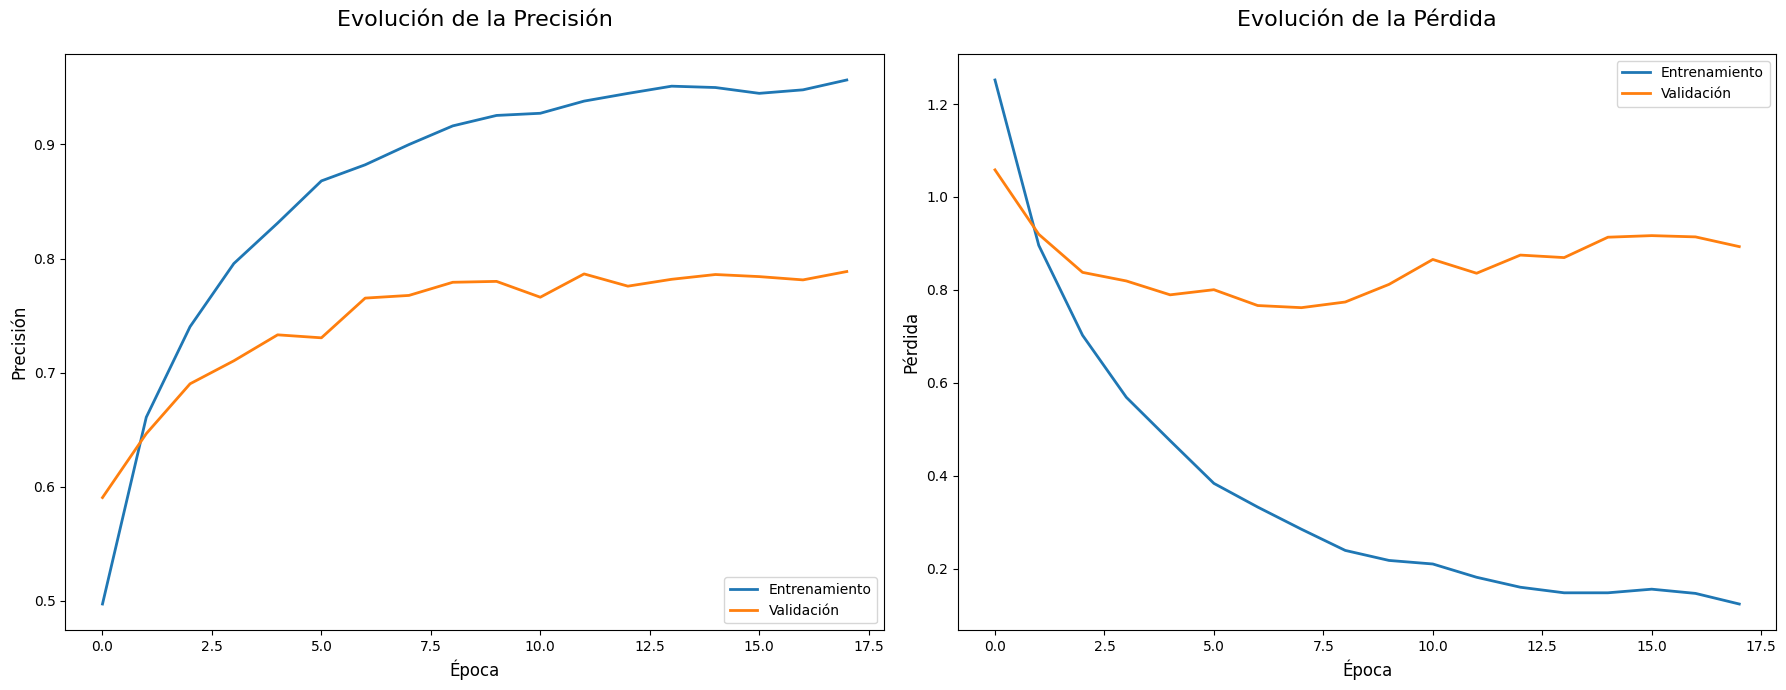

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo guardado en chess_nn_model.h5, chess_nn_model.keras y chess_nn_model_data.joblib
Modelo cargado desde chess_nn_model

Resultado del análisis:
Estilo detectado: Estilo completo y versátil
Campeón recomendado: Spassky, Boris
Apertura sugerida: Sistema Londres (D02)


In [ ]:
analyzer = ChessStyleAnalyzer()
if analyzer.process_pgns():
    analyzer.train_model()
    analyzer.save_model("chess_nn_model")
    pgn_example = """
    [Event "Rated blitz game"]
    [Site "https://lichess.org/zH5ybUle"]
    [Date "2025.05.02"]
    [White "Noc_sniper"]
    [Black "ContadorEnmascarado"]
    [Result "1-0"]
    [GameId "zH5ybUle"]
    [UTCDate "2025.05.02"]
    [UTCTime "21:22:14"]
    [WhiteElo "2093"]
    [BlackElo "2067"]
    [WhiteRatingDiff "+5"]
    [BlackRatingDiff "-6"]
    [Variant "Standard"]
    [TimeControl "180+0"]
    [ECO "B01"]
    [Opening "Scandinavian Defense: Main Line, Mieses Variation"]
    [Termination "Normal"]
    [Annotator "lichess.org"]

    1. e4 { [%eval 0.18] [%clk 0:03:00] } 1... d5 { [%eval 0.54] [%clk 0:03:00] } 2. exd5 { [%eval 0.51] [%clk 0:02:59] } 2... Qxd5 { [%eval 0.52] [%clk 0:03:00] } 3. Nc3 { [%eval 0.47] [%clk 0:02:58] } 3... Qa5 { [%eval 0.45] [%clk 0:02:59] } 4. d4 { [%eval 0.56] [%clk 0:02:58] } 4... Nf6 { [%eval 0.52] [%clk 0:02:58] } { B01 Scandinavian Defense: Main Line, Mieses Variation } 5. Nf3 { [%eval 0.5] [%clk 0:02:58] } 5... Bg4 { [%eval 0.87] [%clk 0:02:57] } 6. Bd2 { [%eval 0.49] [%clk 0:02:57] } 6... Nc6?! { (0.49 → 1.41) Inaccuracy. Qf5 was best. } { [%eval 1.41] [%clk 0:02:56] } (6... Qf5 7. Bd3 Bxf3 8. gxf3 Qd7 9. Ne4 e6 10. c3 c5 11. Nxf6+) 7. h3? { (1.41 → -0.11) Mistake. d5 was best. } { [%eval -0.11] [%clk 0:02:57] } (7. d5 Ne5 8. Nb5 Qb6 9. Be3 Qa5+ 10. c3 c5 11. dxc6 Bxf3) 7... Bh5?? { (-0.11 → 1.94) Blunder. Bxf3 was best. } { [%eval 1.94] [%clk 0:02:55] } (7... Bxf3 8. Qxf3 O-O-O 9. Nb5 Qb6 10. Be3 a6 11. O-O-O axb5 12. d5) 8. Ne4?? { (1.94 → -0.25) Blunder. g4 was best. } { [%eval -0.25] [%clk 0:02:49] } (8. g4 Bg6 9. Nb5 Qb6 10. c4 Nxd4 11. Nbxd4 O-O-O 12. Qb3 Be4) 8... Qd5?! { (-0.25 → 0.53) Inaccuracy. Qb6 was best. } { [%eval 0.53] [%clk 0:02:53] } (8... Qb6 9. Nxf6+) 9. Nxf6+ { [%eval 0.51] [%clk 0:02:47] } 9... gxf6 { [%eval 0.82] [%clk 0:02:53] } 10. Be3? { (0.82 → -0.62) Mistake. c4 was best. } { [%eval -0.62] [%clk 0:02:45] } (10. c4) 10... O-O-O { [%eval -0.67] [%clk 0:02:52] } 11. Be2 { [%eval -1.09] [%clk 0:02:43] } 11... Rg8?! { (-1.09 → -0.21) Inaccuracy. e5 was best. } { [%eval -0.21] [%clk 0:02:46] } (11... e5 12. c3 exd4 13. cxd4 Rg8 14. Kf1 Bg6 15. Qb3 Qd7 16. Bd3 Bxd3+ 17. Qxd3) 12. c3? { (-0.21 → -1.86) Mistake. c4 was best. } { [%eval -1.86] [%clk 0:02:42] } (12. c4 Qa5+) 12... e5? { (-1.86 → -0.35) Mistake. Rxg2 was best. } { [%eval -0.35] [%clk 0:02:42] } (12... Rxg2 13. c4) 13. g4?! { (-0.35 → -1.02) Inaccuracy. dxe5 was best. } { [%eval -1.02] [%clk 0:02:40] } (13. dxe5 Qa5 14. Qc2 Bg6 15. Qb3 Nxe5 16. Nxe5 Qxe5 17. Qa4 a6 18. Qg4+ Kb8) 13... e4?? { (-1.02 → 2.80) Blunder. Bg6 was best. } { [%eval 2.8] [%clk 0:02:37] } (13... Bg6) 14. Nd2? { (2.80 → 1.52) Mistake. gxh5 was best. } { [%eval 1.52] [%clk 0:02:36] } (14. gxh5 exf3 15. Bxf3 Qe6 16. Qb3 Na5 17. Qxe6+ fxe6 18. Be2 f5 19. O-O-O Bd6) 14... Bg6 { [%eval 1.45] [%clk 0:02:35] } 15. Qb3 { [%eval 1.22] [%clk 0:02:34] } 15... Qa5?! { (1.22 → 1.85) Inaccuracy. f5 was best. } { [%eval 1.85] [%clk 0:02:33] } (15... f5) 16. O-O-O { [%eval 1.79] [%clk 0:02:32] } 16... f5 { [%eval 2.24] [%clk 0:02:28] } 17. Nc4 { [%eval 2.05] [%clk 0:02:23] } 17... Qa6?? { (2.05 → 4.76) Blunder. Qd5 was best. } { [%eval 4.76] [%clk 0:02:26] } (17... Qd5 18. Qa4 fxg4 19. Ne5 gxh3 20. Bb5 Nb8 21. Bc4 Qd6 22. Qxa7 Qf6 23. Rxh3) 18. Nd6+ { [%eval 4.67] [%clk 0:02:20] } 18... Bxd6 { [%eval 4.97] [%clk 0:02:25] } 19. Bxa6 { [%eval 4.94] [%clk 0:02:20] } 19... bxa6 { [%eval 4.88] [%clk 0:02:24] } 20. Qa4 { [%eval 4.43] [%clk 0:02:18] } 20... Kb7 { [%eval 4.3] [%clk 0:02:22] } 21. d5 { [%eval 4.18] [%clk 0:02:15] } 21... Ne5 { [%eval 3.91] [%clk 0:02:19] } 22. Qd4 { [%eval 4.05] [%clk 0:02:07] } 22... Nd3+ { [%eval 4.82] [%clk 0:02:12] } 23. Rxd3 { [%eval 4.85] [%clk 0:02:04] } 23... exd3 { [%eval 4.67] [%clk 0:02:12] } 24. Qxa7+ { [%eval 4.7] [%clk 0:02:03] } 24... Kc8 { [%eval 4.33] [%clk 0:02:11] } 25. Qxa6+ { [%eval 4.51] [%clk 0:02:00] } 25... Kd7 { [%eval 4.89] [%clk 0:02:11] } 26. Qc6+ { [%eval 4.8] [%clk 0:01:58] } 26... Ke7 { [%eval 4.87] [%clk 0:02:09] } 27. Kd2 { [%eval 4.59] [%clk 0:01:51] } 27... f4 { [%eval 5.2] [%clk 0:02:08] } 28. Bd4 { [%eval 5.05] [%clk 0:01:49] } 28... f6 { [%eval 6.17] [%clk 0:02:05] } 29. c4 { [%eval 4.97] [%clk 0:01:44] } 29... Rge8 { [%eval 5.05] [%clk 0:01:57] } 30. c5 { [%eval 4.63] [%clk 0:01:42] } 30... Be5 { [%eval 4.63] [%clk 0:01:56] } 31. d6+ { [%eval 4.61] [%clk 0:01:37] } 31... cxd6 { [%eval 4.49] [%clk 0:01:54] } 32. cxd6+ { [%eval 4.38] [%clk 0:01:37] } 32... Rxd6 { [%eval 4.53] [%clk 0:01:53] } 33. Qc7+ { [%eval 4.02] [%clk 0:01:33] } 33... Rd7?! { (4.02 → 6.10) Inaccuracy. Ke6 was best. } { [%eval 6.1] [%clk 0:01:53] } (33... Ke6 34. Bc3 f3 35. Re1 Re7 36. Qc5 Kd7 37. Bxe5 Rxe5 38. Rxe5 fxe5 39. h4) 34. Qc5+?? { (6.10 → 2.56) Blunder. Bc5+ was best. } { [%eval 2.56] [%clk 0:01:31] } (34. Bc5+ Ke6 35. Qc6+ Kf7 36. Qxd7+ Kg8 37. Re1 h6 38. f3 Rb8 39. b4 Re8) 34... Bd6? { (2.56 → 4.43) Mistake. Kf7 was best. } { [%eval 4.43] [%clk 0:01:51] } (34... Kf7 35. Bxe5 Rxe5 36. Qc4+ Kg7 37. Re1 Rxe1 38. Kxe1 Bf7 39. Qb5 d2+ 40. Kd1) 35. Re1+ { [%eval 4.51] [%clk 0:01:27] } 35... Kf7 { [%eval 4.7] [%clk 0:01:48] } 36. Qd5+?! { (4.70 → 3.73) Inaccuracy. Qc4+ was best. } { [%eval 3.73] [%clk 0:01:26] } (36. Qc4+ Kf8 37. Rxe8+ Bxe8 38. Bc3 Rc7 39. Qe6 Be7 40. h4 Bf7 41. Qb6 Rc5) 36... Kg7 { [%eval 3.5] [%clk 0:01:45] } 37. Bc3 { [%eval 3.6] [%clk 0:01:06] } 37... Red8?! { (3.60 → 4.79) Inaccuracy. Rxe1 was best. } { [%eval 4.79] [%clk 0:01:38] } (37... Rxe1 38. Kxe1 Re7+ 39. Kd1 Be5 40. Qc5 Re6 41. g5 Bxc3 42. Qxc3 Bf5 43. gxf6+) 38. Qe6 { [%eval 4.52] [%clk 0:00:59] } 38... f3?? { (4.52 → Mate in 3) Checkmate is now unavoidable. Rf7 was best. } { [%eval #3] [%clk 0:01:36] } (38... Rf7 39. g5 Kf8 40. gxf6 f3 41. Qg4 Rc7 42. Qd4 Kf7 43. h4 h6 44. Re3) 39. Qxf6+ { [%eval #2] [%clk 0:00:57] } 39... Kg8 { [%eval #2] [%clk 0:01:33] } 40. Qh8+ { [%eval #1] [%clk 0:00:48] } 40... Kf7 { [%eval #1] [%clk 0:01:32] } 41. Qf6+ { [%eval #2] [%clk 0:00:47] } 41... Kg8 { [%eval #2] [%clk 0:01:31] } 42. h4?? { (Mate in 2 → 5.31) Lost forced checkmate sequence. Qh8+ was best. } { [%eval 5.31] [%clk 0:00:47] } (42. Qh8+ Kf7 43. Qg7#) 42... Bf4+?! { (5.31 → 8.64) Inaccuracy. Bf8 was best. } { [%eval 8.64] [%clk 0:01:30] } (42... Bf8 43. Qh8+ Kf7 44. g5 Re7 45. Qf6+ Ke8 46. Re5 Rc8 47. Rxe7+ Bxe7 48. Qe6) 43. Qxf4 { [%eval 8.4] [%clk 0:00:45] } 43... Rf7? { (8.40 → Mate in 4) Checkmate is now unavoidable. Rd4 was best. } { [%eval #4] [%clk 0:01:29] } (43... Rd4 44. Qf6 R8d6 45. Qe5 R6d5 46. Bxd4 Rxe5 47. Rxe5 Kg7 48. h5 Bf7 49. b3) 44. Qg5? { (Mate in 4 → 8.30) Lost forced checkmate sequence. Qe5 was best. } { [%eval 8.3] [%clk 0:00:41] } (44. Qe5 Rd4 45. Qxd4 Re7 46. Rxe7 Bf7 47. Qg7#) 44... Rfd7? { (8.30 → Mate in 4) Checkmate is now unavoidable. Rdf8 was best. } { [%eval #4] [%clk 0:01:21] } (44... Rdf8 45. Re3 Rc8 46. Qe5 Rxc3 47. Qxc3 Rf4 48. Qc7 Rf6 49. Re7 Bf7 50. b3) 45. h5 { [%eval #4] [%clk 0:00:39] } 45... Rd5 { [%eval #4] [%clk 0:01:21] } 46. Qf6 { [%eval #3] [%clk 0:00:34] } 46... Bf7 { [%eval #1] [%clk 0:01:18] } 47. Qg7# { [%clk 0:00:33] } { White wins by checkmate. } 1-0
    """

    loaded_analyzer = ChessStyleAnalyzer.load_model("chess_nn_model")
    champion, desc, (eco, opening) = loaded_analyzer.recommend_opening(pgn_example)

    print("\nResultado del análisis:")
    print(f"Estilo detectado: {desc}")
    print(f"Campeón recomendado: {champion}")
    print(f"Apertura sugerida: {opening} ({eco})")